Here I attempt to add a feature to our theoretical model: I add the fact that patents only have a 75% chance of getting cited by future patents within their technology cluster. 75% came from the estimate in AK2016.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#Setting plot colors
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

In [2]:
#Loading data as a pandas dataset
data2 = pd.read_csv('cit_external_comn_share.csv', sep = ',', header = 0, index_col = 0)
#Deleting patents before 1976
data2 = data2[data2.appyear > 1975]

C:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
abr_cut = 0.1
data2['external_share'] = data2.external_share.replace(np.nan, -1)
level = np.rint(np.size(data2['tot_cit_correct'].dropna())
                                                   - abr_cut * np.size(data2['tot_cit_correct'].
                                                                   dropna()))
cutoff = np.sort(data2['tot_cit_correct'].dropna())[int(level)]
cutoff

10.6616

In [4]:
#This function will be used to determine whether a patent is abrupt or incremental.
#A patent at the top 10% of expected citations is set to be aprupt

def abrupt(cites, cutoff):
    #The cutoff value that defines an abrupt innovation can be adjusted
    if cites >= cutoff:
        return 0
    else:
        return 1
    
#Creating a new column for the indicator variable 'incremental'
data2['Increment'] = data2['tot_cit_correct'].apply(abrupt, cutoff = cutoff)
data2['tot_abr_inc_cit_correct'] = data2['tot_cit_correct'] - data2['tot_external_correct']
data2['tot_abr_class_cit_correct'] = data2['tot_cit_correct'] - data2['tot_external_class_correct']

#Defining External Patents
#The definition will depend on the share of citations that are external.
#That variable has many missing values for patents with no citations. This line replaces
#those missing values with -1. 
data2['external_share'] = data2.external_share.replace(np.nan, -1)
#Now I define a function to determine whether a patent is external
def external(cites):
    cutoff = 0.5
    if cites >= cutoff:
        return 1
    else:
        return 0
data2['External'] = data2['external_share'].apply(external)
print(np.mean(data2['Increment']))

0.899991542938089


In [5]:
def pdf_eta2(lambda_inc_0, alpha, tau_lambda_int_abr, ndim):
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0] + tau_lambda_int_abr)
    #eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0])
    eta_k_mod = [None] * ndim
    eta_k_mod[0] = eta_0
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_k_mod[i-1] * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))
    '''
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_0 * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))**i
    '''
    return eta_k_mod

def pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr):
    
    eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0] + tau_lambda_int_abr)
    eta_k_mod = [None] * len(lambda_inc_k)
    eta_k_mod[0] = eta_0
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_k_mod[i-1] * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))
    
    return eta_k_mod

def pdf_citations(lambda_inc_0, tau_lambda_int_abr, alpha, ndim):
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    etas = pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr)
    pmf = np.zeros(len(etas))
    M = np.zeros((len(etas), len(etas)))
    for i in range(0, len(etas)):
        for j in range(0, len(etas)):
            M[i][j] = sts.binom.pmf(i, j, .75)
    pmf = np.dot(M, etas)
    '''
    for i in range(0, len(etas)):
        for j in range(0, len(etas)):
            pmf[i] += etas[j]*sts.binom.pmf(i, j, .75)
    '''
    
    return pmf

0.999999370169
0.999999370169


<IPython.core.display.Javascript object>


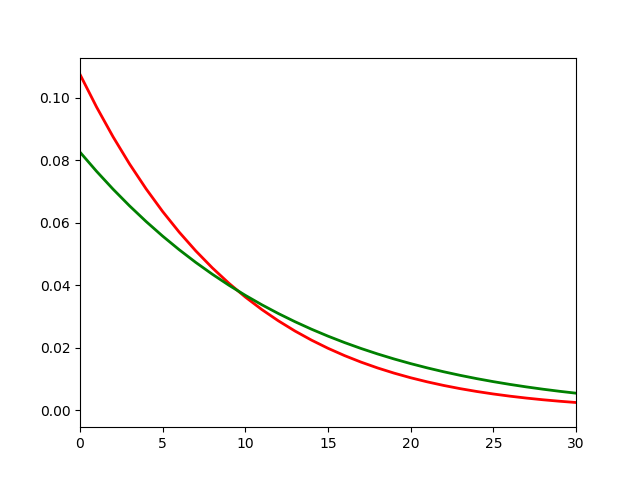

(0, 30)

In [6]:
ndim = 100
lambda_inc_0_test, alpha_test, tau_lambda_int_abr_test = 1.0, .99 , .09
pmf = pdf_citations(lambda_inc_0_test, tau_lambda_int_abr_test, alpha_test, ndim)
print(np.sum(pmf))
pmf2 = pdf_eta2(lambda_inc_0_test, alpha_test, tau_lambda_int_abr_test, ndim)
print(np.sum(pmf2))

dist_pts = np.arange(ndim)
plt.figure(7)
plt.plot(dist_pts, pmf,
         linewidth=2, color='r')
plt.plot(dist_pts, pmf2,
         linewidth=2, color='g')
plt.xlim([0, 30])

In [7]:
def pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr):
    
    eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0] + tau_lambda_int_abr)
    eta_k_mod = [None] * len(lambda_inc_k)
    eta_k_mod[0] = eta_0
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_k_mod[i-1] * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))
    
    return eta_k_mod

def pdf_citations(lambda_inc_k, tau_lambda_int_abr, M):
    etas = pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr)
    pmf = np.dot(M, etas)
    
    return pmf

def log_lik(xvals, lambda_inc_k, alpha, tau_lambda_int_abr):
    lik_array = np.zeros(len(xvals))
    pmf = pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr)
    rounded = np.round(xvals)
    for n in range(0, len(xvals)):
        lik_array[n] = pmf[np.int(rounded[n])]
    
    lik_array[lik_array < 1e-20] = 1e-20
    loglik_array = np.log(lik_array)
    
    return np.sum(loglik_array)

def log_lik2(xvals, lambda_inc_k, alpha, tau_lambda_int_abr, M):
    lik_array = np.zeros(len(xvals))
    pmf = pdf_citations(lambda_inc_k, tau_lambda_int_abr, M)
    rounded = np.round(xvals)
    for n in range(0, len(xvals)):
        lik_array[n] = pmf[np.int(rounded[n])]
    
    lik_array[lik_array < 1e-20] = 1e-20
    loglik_array = np.log(lik_array)
    
    return np.sum(loglik_array)

def crit(params, *args):
    tau_lambda_int_abr, alpha = params
    xvals, W, ndim = args
    lambda_inc_0 = 1.0
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    loglik = log_lik(xvals, lambda_inc_k, alpha, tau_lambda_int_abr)
    crit_val = -loglik
    #print(params, crit_val)
    
    return crit_val

def crit2(params, *args):
    tau_lambda_int_abr, alpha = params
    xvals, M, ndim = args
    lambda_inc_0 = 1.0
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    loglik = log_lik2(xvals, lambda_inc_k, alpha, tau_lambda_int_abr, M)
    crit_val = -loglik
    #print(params, crit_val)
    
    return crit_val

In [12]:
cit_abr = data2[(data2.Increment == 0)]
#cit_abr = cit_abr[cit_abr.tot_abr_class_cit_correct < 50]

tau_lambda_int_abr_init = .09
lambda_inc_0_init = 0.5
alpha_init = 0.95
params_init = np.array([tau_lambda_int_abr_init, alpha_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5))
ndim = 100
M = np.zeros((ndim, ndim))
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, M, ndim)

results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)
'''
results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='Nelder-Mead')
'''

tau_lambda_int_abr_MLE, alpha_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= 0.103626155403 alpha_MLE= 0.99999
-log likelihood = 627597.098102


In [29]:
cit_abr = data2[(data2.Increment == 0)]

tau_lambda_int_abr_init = .09
lambda_inc_0_init = 0.5
alpha_init = 0.5
params_init = np.array([tau_lambda_int_abr_init, alpha_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5))
ndim = 100
M = np.zeros((ndim, ndim))
prob = .75
for i in range(0, ndim):
    for j in range(0, ndim):
        M[i][j] = sts.binom.pmf(i, j, prob)
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, M, ndim)

results_MLE = opt.minimize(crit2, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)
'''
results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='Nelder-Mead')
'''

tau_lambda_int_abr_MLE, alpha_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= 0.0795743819735 alpha_MLE= 0.99999
-log likelihood = 669910.885896


In [10]:
def crit3(params, *args):
    tau_lambda_int_abr, alpha, prob = params
    xvals, ndim = args
    M = np.zeros((ndim, ndim))
    for i in range(0, ndim):
        for j in range(0, ndim):
            M[i][j] = sts.binom.pmf(i, j, prob)
    lambda_inc_0 = 1.0
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    loglik = log_lik2(xvals, lambda_inc_k, alpha, tau_lambda_int_abr, M)
    crit_val = -loglik
    print(params, crit_val)
    
    return crit_val

In [13]:
cit_abr = data2[(data2.Increment == 0)]
#cit_abr = cit_abr[cit_abr.tot_abr_class_cit_correct < 50]

tau_lambda_int_abr_init = .09
prob_init = 0.5
alpha_init = 0.9
params_init = np.array([tau_lambda_int_abr_init, alpha_init, prob_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5), (1e-5, 1-1e-5))
ndim = 100
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, ndim)

results_MLE = opt.minimize(crit3, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)
'''
results_MLE = opt.minimize(crit3, params_init, args=(gmm_args),
                                 method='Nelder-Mead')
'''

tau_lambda_int_abr_MLE, alpha_MLE, prob_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE, 'prob_MLE=', prob_MLE)
print('-log likelihood =', results_MLE.fun)

[ 0.09  0.9   0.5 ] 1330639.85874
[ 0.09000001  0.9         0.5       ] 1330639.89305
[ 0.09        0.90000001  0.5       ] 1330639.7986
[ 0.09        0.9         0.50000001] 1330639.84596
[  1.00000000e-05   9.99990000e-01   9.99990000e-01] 2178327.45824
[  1.00100000e-05   9.99990000e-01   9.99990000e-01] 2178138.36593
[  1.00000000e-05   9.99990010e-01   9.99990000e-01] 2178327.47649
[  1.00000000e-05   9.99990000e-01   9.99990010e-01] 2178327.45876
[ 0.04548491  0.94946176  0.74732857] 795179.709449
[ 0.04548492  0.94946176  0.74732857] 795179.718039
[ 0.04548491  0.94946177  0.74732857] 795179.674356
[ 0.04548491  0.94946176  0.74732858] 795179.707401
[ 0.03993335  0.99999     0.79376552] 699174.423724
[ 0.03993336  0.99999     0.79376552] 699174.400095
[ 0.03993335  0.99999001  0.79376552] 699174.430405
[ 0.03993335  0.99999     0.79376553] 699174.422779
[ 0.0547138   0.99999     0.78571089] 675480.947566
[ 0.05471381  0.99999     0.78571089] 675480.936533
[ 0.0547138   0.9999900

In [14]:
#This runs the optimization with p=1 when the upper tail of the distribution is eliminated
cit_abr = data2[(data2.Increment == 0)]
cit_abr = cit_abr[cit_abr.tot_abr_class_cit_correct < 50]

tau_lambda_int_abr_init = .09
lambda_inc_0_init = 0.5
alpha_init = 0.95
params_init = np.array([tau_lambda_int_abr_init, alpha_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5))
ndim = 100
M = np.zeros((ndim, ndim))
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, M, ndim)

results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)
'''
results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='Nelder-Mead')
'''

tau_lambda_int_abr_MLE, alpha_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= 0.127039761201 alpha_MLE= 0.99999
-log likelihood = 575622.14203


In [18]:
#This runs the optimization with flexible probability when the upper tail of the distribution is eliminated
cit_abr = data2[(data2.Increment == 0)]
cit_abr = cit_abr[cit_abr.tot_abr_class_cit_correct < 50]

tau_lambda_int_abr_init = .09
prob_init = 0.9
alpha_init = 0.9
params_init = np.array([tau_lambda_int_abr_init, alpha_init, prob_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5), (1e-5, 1-1e-5))
ndim = 100
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, ndim)

results_MLE = opt.minimize(crit3, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)
'''
results_MLE = opt.minimize(crit3, params_init, args=(gmm_args),
                                 method='Nelder-Mead')
'''

tau_lambda_int_abr_MLE, alpha_MLE, prob_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE, 'prob_MLE=', prob_MLE)
print('-log likelihood =', results_MLE.fun)

[ 0.09  0.9   0.9 ] 793118.421715
[ 0.09000001  0.9         0.9       ] 793118.442571
[ 0.09        0.90000001  0.9       ] 793118.375381
[ 0.09        0.9         0.90000001] 793118.417213
[  1.00000000e-05   9.99990000e-01   9.99990000e-01] 2121233.49235
[  1.00100000e-05   9.99990000e-01   9.99990000e-01] 2121049.35276
[  1.00000000e-05   9.99990010e-01   9.99990000e-01] 2121233.50685
[  1.00000000e-05   9.99990000e-01   9.99990010e-01] 2121233.4942
[ 0.05229477  0.94189517  0.94189517] 617915.93714
[ 0.05229478  0.94189517  0.94189517] 617915.933023
[ 0.05229477  0.94189518  0.94189517] 617915.927357
[ 0.05229477  0.94189517  0.94189518] 617915.936958
[ 0.05854744  0.9530414   0.94443489] 605944.158387
[ 0.05854745  0.9530414   0.94443489] 605944.153624
[ 0.05854744  0.95304141  0.94443489] 605944.151682
[ 0.05854744  0.9530414   0.9444349 ] 605944.158443
[ 0.09838924  0.9952466   0.94539817] 578552.880287
[ 0.09838925  0.9952466   0.94539817] 578552.877875
[ 0.09838924  0.99524661

In [17]:
print(crit3((.0939, .99999, .73918), MLE_data, ndim))
print(crit3((.12704, .99999, 1.0), MLE_data, ndim))

(0.0939, 0.99999, 0.73918) 575622.707578
575622.707578
(0.12704, 0.99999, 1.0) 575622.14203
575622.14203
